# Computer vision: LeNet-5 and Distortions
Import various modules that we need for this notebook.

In [1]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### I. LeNet-5 for MNIST10
Here is my attempt to replicate the LeNet-5 model as closely as possibly the original paper: LeCun, Yann, Léon Bottou, Yoshua Bengio, and Patrick Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86, no. 11 (1998): 2278-2324.

As few modern neural network libraries allow for partially connected convolution layers, I've substituted this with a dropout layer. I've also replaced momentum with the Hessian approximation, and rescaled the learning rate schedule, though the proportional decay remains the same.

In [8]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (1, 28, 28)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))

model.add(Convolution2D(16,                        5, 5, border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

model.add(Convolution2D(120, 1, 1, border_mode='valid'))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation('softmax'))

ValueError: Negative dimension size caused by subtracting 5 from 1 for 'Conv2D_4' (op: 'Conv2D') with input shapes: [?,1,28,28], [5,5,28,6].

In [4]:
l_rate = 1
sgd = SGD(lr=l_rate, momentum=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=2,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.8 * l_rate, momentum=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=3,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.4 * l_rate, momentum=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=3,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.2 * l_rate, momentum=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=4,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.08 * l_rate, momentum=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, nb_epoch=8,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

/home/vit/tensorflow/lib/python2.7/site-packages/keras/models.py:412: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 12s - loss: 2.3383 - val_loss: 2.3201
Epoch 2/2
60000/60000 [==============================] - 12s - loss: 2.3380 - val_loss: 2.3365
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 11s - loss: 2.3304 - val_loss: 2.3465
Epoch 2/3
60000/60000 [==============================] - 11s - loss: 2.3298 - val_loss: 2.3201
Epoch 3/3
60000/60000 [==============================] - 12s - loss: 2.3296 - val_loss: 2.3253
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 11s - loss: 2.3153 - val_loss: 2.3188
Epoch 2/3
60000/60000 [==============================] - 12s - loss: 2.3157 - val_loss: 2.3175
Epoch 3/3
60000/60000 [==============================] - 12s - loss: 2.3157 - val_loss: 2.3111
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [=================

In [8]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


 9824/10000 [============================>.] - ETA: 0s('Test score:', 2.3038032814025877)
('Test accuracy:', 0.098000000000000004)


In [9]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 2.3038032814025877)
('Test accuracy:', 0.098000000000000004)


In [13]:
batch_size = 128
nb_classes = 10
nb_epoch = 15
 
    # input image dimensions
img_rows, img_cols = 28, 28
    # number of convolutional filters to use
nb_filters = 32
    # size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3
    # data threshold
train_counts = 10000
testing_counts = 1000
 
    
    
    # the data, shuffled and split between train and test sets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
 
    # convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
 
model = Sequential()
 
model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
 
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 17s - loss: 0.3493 - acc: 0.8924 - val_loss: 0.0842 - val_acc: 0.9731
Epoch 2/15
60000/60000 [==============================] - 17s - loss: 0.1249 - acc: 0.9625 - val_loss: 0.0579 - val_acc: 0.9823
Epoch 3/15
60000/60000 [==============================] - 17s - loss: 0.0981 - acc: 0.9710 - val_loss: 0.0494 - val_acc: 0.9832
Epoch 4/15
60000/60000 [==============================] - 17s - loss: 0.0858 - acc: 0.9743 - val_loss: 0.0442 - val_acc: 0.9847
Epoch 5/15
60000/60000 [==============================] - 17s - loss: 0.0736 - acc: 0.9785 - val_loss: 0.0382 - val_acc: 0.9863
Epoch 6/15
60000/60000 [==============================] - 17s - loss: 0.0653 - acc: 0.9806 - val_loss: 0.0352 - val_acc: 0.9875
Epoch 7/15
60000/60000 [==============================] - 17s - loss: 0.0608 - acc: 0.9819 - v

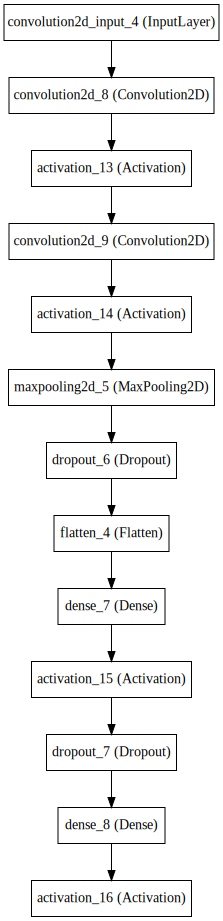

In [36]:
import pydot_ng 
import pydot

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [37]:
# serialize model to JSON
model_json = model.to_json()
with open("modelL5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelL5.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                print("      {}: {}".format(p_name, param.shape))
    finally:
        f.close()

In [39]:
print_structure('modelL5.h5')

modelL5.h5 contains: 
Root attributes:
  layer_names: ['convolution2d_8' 'activation_13' 'convolution2d_9' 'activation_14'
 'maxpooling2d_5' 'dropout_6' 'flatten_4' 'dense_7' 'activation_15'
 'dropout_7' 'dense_8' 'activation_16']
  activation_13
    Attributes:
      weight_names: []
    Dataset:
  activation_14
    Attributes:
      weight_names: []
    Dataset:
  activation_15
    Attributes:
      weight_names: []
    Dataset:
  activation_16
    Attributes:
      weight_names: []
    Dataset:
  convolution2d_8
    Attributes:
      weight_names: ['convolution2d_8_W:0' 'convolution2d_8_b:0']
    Dataset:
      convolution2d_8_W:0: (32, 1, 3, 3)
      convolution2d_8_b:0: (32,)
  convolution2d_9
    Attributes:
      weight_names: ['convolution2d_9_W:0' 'convolution2d_9_b:0']
    Dataset:
      convolution2d_9_W:0: (32, 32, 3, 3)
      convolution2d_9_b:0: (32,)
  dense_7
    Attributes:
      weight_names: ['dense_7_W:0' 'dense_7_b:0']
    Dataset:
      dense_7_W:0: (4608, 128)
  

In [41]:
import numpy as np
import pandas as pd
for conf in model.get_config():
    print '--------------'
    print conf
i=1
for weight in model.get_weights():
    print '--------------'
    weight=np.array(weight)
    print len(weight.shape),weight.shape
   # if len(weight.shape)>2:
   #     if i==1:
   #         w=weight
   #         i=0
        
    np.savetxt("weightsL5_"+str(i)+'.csv', resh(weight), delimiter=",")
    
    
    i=i+1
    

--------------
{'class_name': 'Convolution2D', 'config': {'b_regularizer': None, 'W_constraint': None, 'b_constraint': None, 'name': 'convolution2d_8', 'activity_regularizer': None, 'trainable': True, 'dim_ordering': 'th', 'nb_col': 3, 'subsample': (1, 1), 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 32, 'input_dtype': 'float32', 'border_mode': 'valid', 'batch_input_shape': (None, 1, 28, 28), 'W_regularizer': None, 'activation': 'linear', 'nb_row': 3}}
--------------
{'class_name': 'Activation', 'config': {'activation': 'relu', 'trainable': True, 'name': 'activation_13'}}
--------------
{'class_name': 'Convolution2D', 'config': {'W_constraint': None, 'b_constraint': None, 'name': 'convolution2d_9', 'activity_regularizer': None, 'trainable': True, 'dim_ordering': 'th', 'nb_col': 3, 'subsample': (1, 1), 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 32, 'border_mode': 'valid', 'b_regularizer': None, 'W_regularizer': None, 'activation': 'linear', 'nb_row': 3}}
--------------

In [27]:
w.shape

(6, 1, 5, 5)

In [40]:
def resh(w):
    if len(w.shape)>2:
        i=0
        w1=1
        w2=1
        for l in w.shape:
            if i==0:
                w1=l
                i=1
            else:
                w2=w2*l
        
        print w2
        return np.reshape(w,(w1,w2))
    else:
        return w
resh(w)
    

NameError: name 'w' is not defined

In [39]:
np.reshape(w,(6,25)).shape

(6, 25)

In [34]:
len(w.shape)
for sl in w:
    print sl.shape


(1, 5, 5)
(1, 5, 5)
(1, 5, 5)
(1, 5, 5)
(1, 5, 5)
(1, 5, 5)


In [37]:
if len(w.shape)>2:
    for sl in w:
        if len(sl.shape)>2:
            for sll in sl:
                print sll.shape

(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


In [31]:
np.reshape(w,(6,25)).shape

(6, 25)

In [16]:
for layer in model.layers:
    weights = layer.get_weights()
    print len(weights)

2
0
0
2
0
0
0
2
0
2
0
2
0


In [20]:
model.evaluate(X_test, Y_test, show_accuracy=True)

 9856/10000 [============================>.] - ETA: 0s

2.3020212547302248